In [274]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [275]:

bag = rosbag.Bag('/home/uware/rosbags/16h5_slz_2-4-6-8-10_360_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6]

In [276]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [277]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,3.102597
1,2.326608,2.813648
2,2.531873,6.702841
3,3.345015,7.057930
4,3.345063,4.474159
...,...,...
1626,120.341166,2.048708
1627,120.370325,2.048708
1628,120.403657,2.048708
1629,120.435393,2.048708


<AxesSubplot:xlabel='relative_time'>

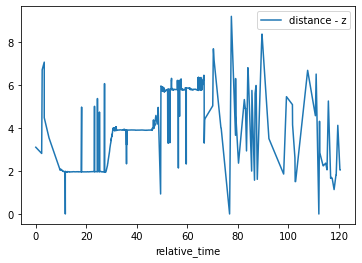

In [278]:
# initial graph
df.plot(x='relative_time', y=target)

In [279]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .01)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [280]:
# the amount of data points we are left with
len(x[peaks])

239

In [281]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

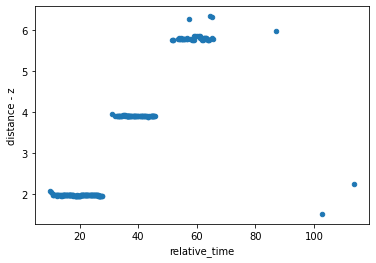

In [282]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [283]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
8,9.803060,2.078962,2
13,10.181702,2.051361,2
22,10.772690,1.995413,2
25,10.909190,1.980662,2
29,11.066601,1.980598,2
...,...,...,...
1514,65.140301,6.332482,6
1528,65.637315,5.777682,6
1581,87.171088,5.971882,6
1598,102.784676,1.506310,2


In [284]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [285]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [286]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
8,9.803060,2.078962,2,-0.078962
13,10.181702,2.051361,2,-0.051361
608,31.004144,3.951965,4,0.048035
642,32.137349,3.894902,4,0.105098
1125,51.605342,5.767455,6,0.232545
1128,51.703090,5.766011,6,0.233989


In [287]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,118.0,0.036017,0.051927,-0.245879,0.030851,0.036791,0.040803,0.493690
4,70.0,0.096006,0.008773,0.048035,0.095149,0.097152,0.100397,0.110584
6,51.0,0.171812,0.128537,-0.340216,0.197630,0.206249,0.222264,0.239916


In [288]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

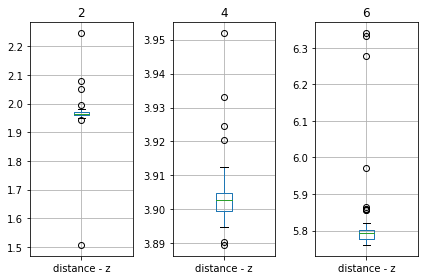

In [289]:
box_plotter(target)

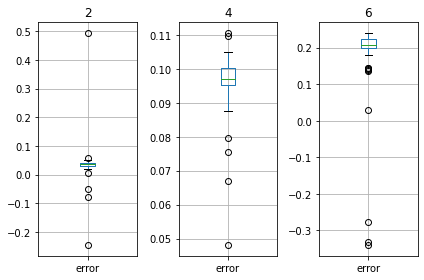

In [290]:
box_plotter('error')